In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd
import os
import pandas as pd
import json

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows 

In [8]:
# global Location variable 
GLOBAL_AREA = 'Westbrueck' 
GLOBAL_SEGMENT = 0

In [2]:
data_path = './data/'

old_reference_data_some_failed_save_path = "./post_recorded_reference_data/old_reference_some_events_failed.pickle"
old_reference_data_all_failed_save_path = "./post_recorded_reference_data/old_reference_all_events_failed.pickle"
OLD_REFERENCE_DATA_SOME_EVENTS_FAILED = load_from_disk(old_reference_data_some_failed_save_path)
OLD_REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(old_reference_data_all_failed_save_path)

reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

In [3]:
print(REFERENCE_DATA_ALL_EVENTS_FAILED["Westbrueck"][0].columns)

Index(['CarPosition.x', 'CarPosition.y', 'CarPosition.z',
       'car_rotation_angles.x', 'car_rotation_angles.y',
       'car_rotation_angles.z', 'car_rotation_direction.x',
       'car_rotation_direction.y', 'car_rotation_direction.z'],
      dtype='object')


# Load data

In [4]:

participant_id = os.path.basename(glob.glob("./data/EyeTracking/*.txt")[0]).split("_")[0]
eyes = glob.glob("./data/EyeTracking/" + str(participant_id) + "*.txt")
inputs = glob.glob("./data/Input/" + str(participant_id) + "*.txt")
calib = glob.glob("./data/ParticipantCalibrationData/" + str(participant_id) + "*.txt")[0]
scenes = glob.glob("./data/SceneData/" + str(participant_id) + "*.txt")

eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]

'''
print(eyes)
print(inputs)
print(calib)
print(scenes)
'''

#participant1 = ParticipantData(eyes, inputs, calib, scenes, True, True)

measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0bc17d704fec4a9eb892d905fc2e5da9.
Input data files: ['./data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Autobahn.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Westbrueck.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_TrainingScene.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_MountainRoad.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_CountryRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Autobahn.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0bc17d704fec4a9eb892d905fc2e5da9_ParticipantCalib

In [5]:
#print(participant1.get_event_info())
#participant1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))

measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
ParticipantData: Applying reference data to back of Coun

# Load Reference and Correlation Data

In [6]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
ParticipantData: Applying reference data to back of Coun

In [7]:
#print(participant1.get_segment_data(filter_data=True, get_first_segment=True, exclude_segments=[1,2], after_event_type_only=[True,False],exclude_areas=["Westbrueck","Autobahn"]))


# Filter data

In [11]:
# Wanted filtering, very much data
'''
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
res = measurement1.truncate_data(filtered_data,200)
print(np.shape(res))
# save_to_disk(res,"./truncated_data.pickle")
'''


# some test filtering
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn","MountainRoad"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
#filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, get_first_segment = True, after_event_type_only=[True,False], exclude_segments=[], exclude_areas = [], exclude_participants=[])
filtered_data = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])

print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9'][GLOBAL_AREA][GLOBAL_SEGMENT].columns) 




#print(filtered_data)
#print(filtered_data['0d0d7bd79b1a48d4ad5e757cdbfc15c9']["Westbrueck"][2].columns)



ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.
Index(['HmdPosition.x', 'HmdPosition.y', 'H

In [12]:
# Average data over multiple sessions per segment
average = measurement1.average_data(filtered_data)

# combine ALL data into one dataframe 
combined = measurement1.combine_data(filtered_data)


In [13]:
# Extract data of one participant, of one area, of one segment 
print("Available participants: " + str(measurement1.get_participant_list()))
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = one_participant_single_segment['0bc17d704fec4a9eb892d905fc2e5da9'][GLOBAL_AREA][GLOBAL_SEGMENT] 

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants[GLOBAL_AREA][GLOBAL_SEGMENT] 



Available participants: ['0bc17d704fec4a9eb892d905fc2e5da9', '0d0d7bd79b1a48d4ad5e757cdbfc15c9']
ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobah

In [14]:
# Extract data of one participant, of one area, of one segment without ref data applied 
one_participant_single_segment_no_ref_applied = measurement1.get_data(use_vanilla=True, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment_no_ref_applied = \
    one_participant_single_segment_no_ref_applied['0bc17d704fec4a9eb892d905fc2e5da9'][GLOBAL_AREA][GLOBAL_SEGMENT]

ref_data_one_participant_single_segment = REFERENCE_DATA_ALL_EVENTS_FAILED[GLOBAL_AREA][GLOBAL_SEGMENT]  




ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.


In [15]:
all_data_one_participant_ref_applied = measurement1.get_data(use_vanilla = False, filter_data=False, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])
all_data_one_participant_vanilla = measurement1.get_data(use_vanilla = True, filter_data=False, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, get_first_segment = False, after_event_type_only=[False], exclude_segments=[3], exclude_areas = ["CountryRoad","Autobahn"], exclude_participants=["0bc17d704fec4a9eb892d905fc2e5da9"])

print("Datapoints one participant original data: " + str(len(measurement1.combine_data(all_data_one_participant_vanilla))))
print("Datapoints one participant reference data applied: " + str(len(measurement1.combine_data(all_data_one_participant_ref_applied))))
print("Datapoints one participant ref. applied, correlation coefficient thresholded: " + str(len(measurement1.combine_data(filtered_data))))





Datapoints one participant original data: 45751
Datapoints one participant reference data applied: 38542
Datapoints one participant ref. applied, correlation coefficient thresholded: 17373


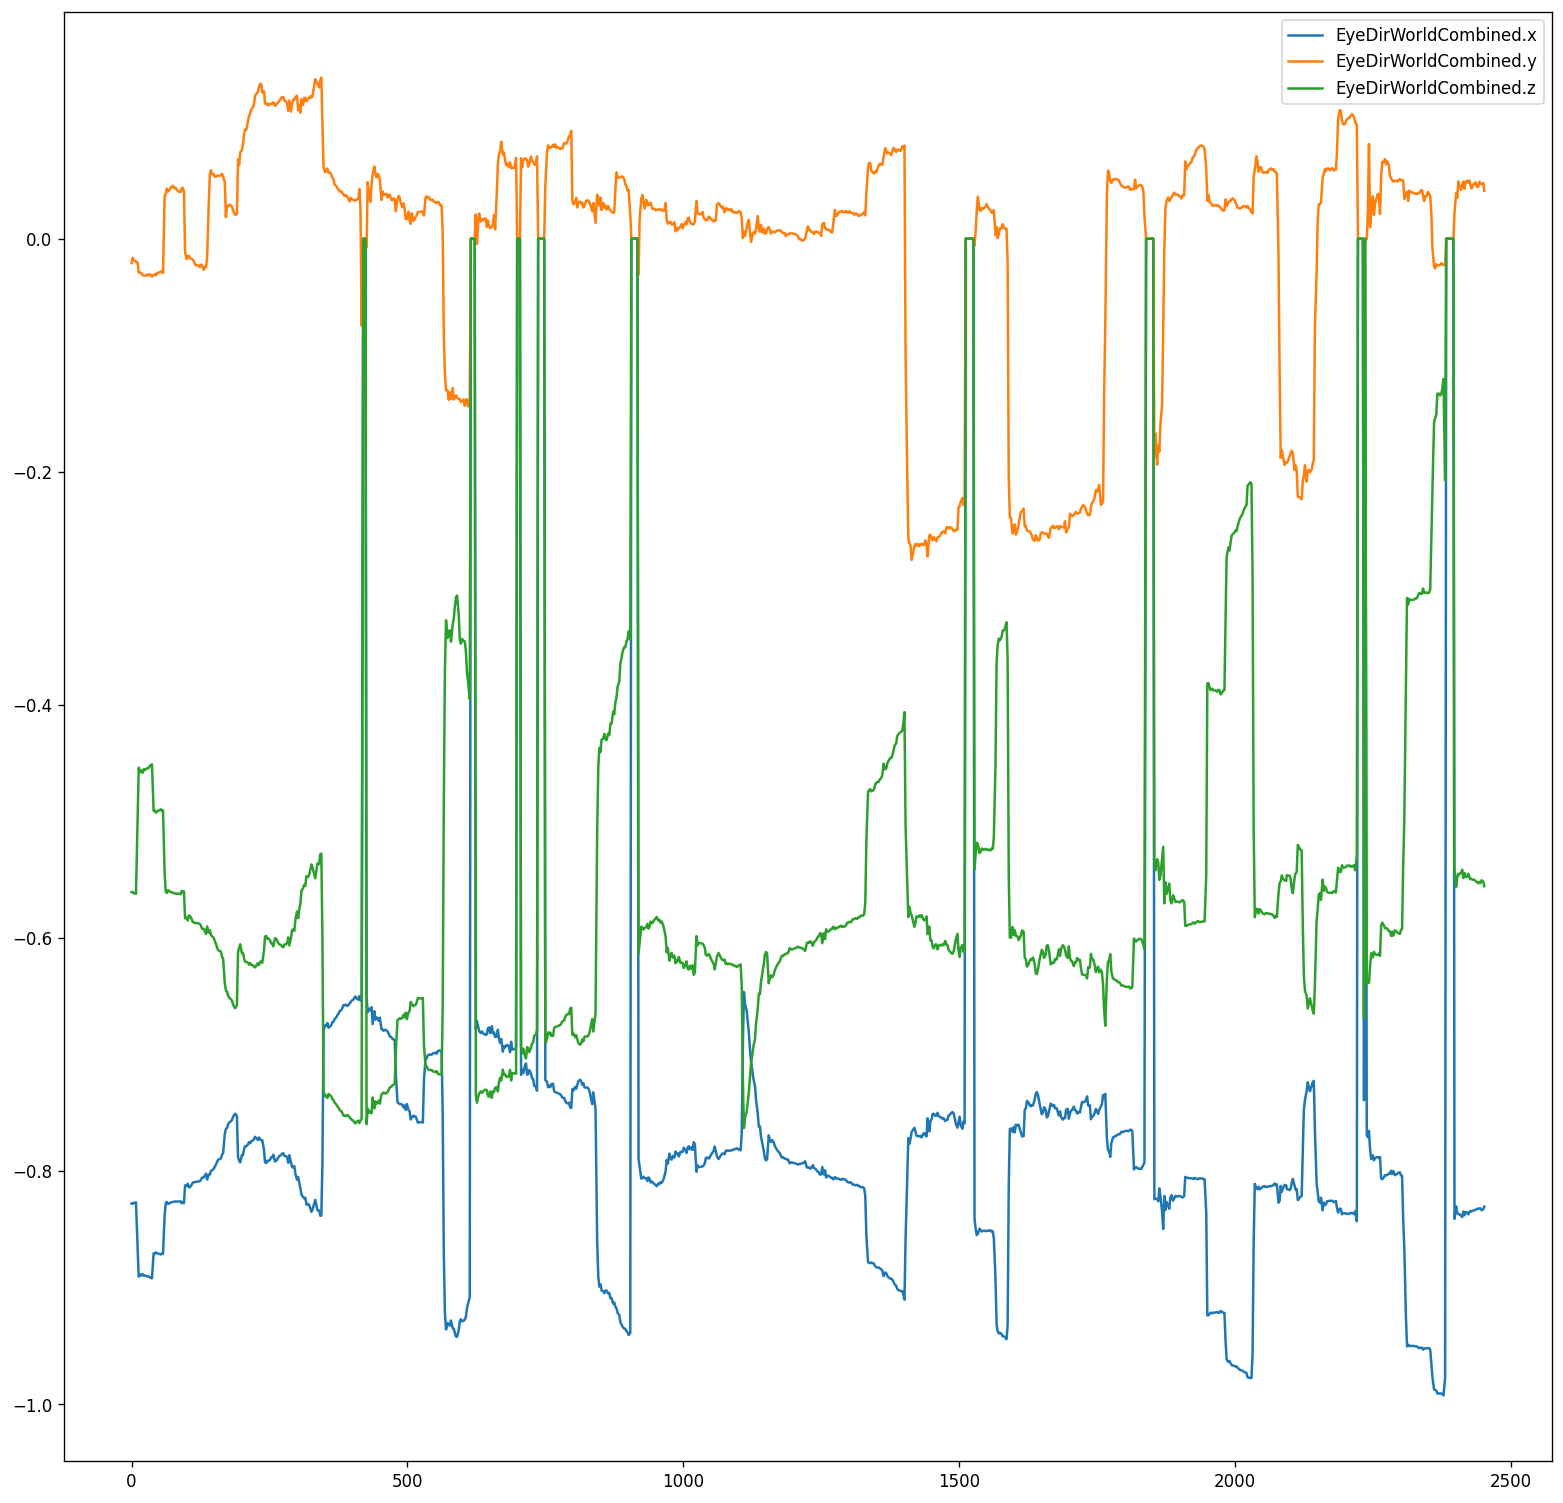

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16), dpi=120)

names_x = ["NoseVector.x","NoseVector.x",'car_rotation_direction.x',"EyeDirWorldCombined.x","EyeDirWorldCombined.x",'car_rotation_direction.x', \
           "NoseVector.y","NoseVector.y",'car_rotation_direction.y',"EyeDirWorldCombined.y","EyeDirWorldCombined.y",'car_rotation_direction.y', \
           "NoseVector.z","NoseVector.z",'car_rotation_direction.z',"EyeDirWorldCombined.z","EyeDirWorldCombined.z",'car_rotation_direction.z', \
           'EyePosWorldCombined.x','EyePosWorldCombined.x','CarPosition.x', \
           'EyePosWorldCombined.y','EyePosWorldCombined.y','CarPosition.y', \
           'EyePosWorldCombined.z','EyePosWorldCombined.z','CarPosition.z'
          ]
x1 = one_participant_single_segment_no_ref_applied[names_x[3]]
x2 = one_participant_single_segment_no_ref_applied[names_x[9]]
x3 = one_participant_single_segment_no_ref_applied[names_x[15]]
ax.plot(x1,label=names_x[3])
ax.plot(x2,label=names_x[9])
ax.plot(x3,label=names_x[15])
ax.legend(loc="upper right")



plt.show()

